In [5]:
import warnings
warnings.filterwarnings("ignore")



radar = pyart.io.read('KDDC20160525_001527_V06.gz')

radar = pyart.io.read('/Volumes/scr1/26Apr_2016/KLSX20160426_183137_V06')
radar = pyart.io.read('KDDC20160524_181120_V06.gz')


In [2]:
display = pyart.graph.RadarDisplay(radar)

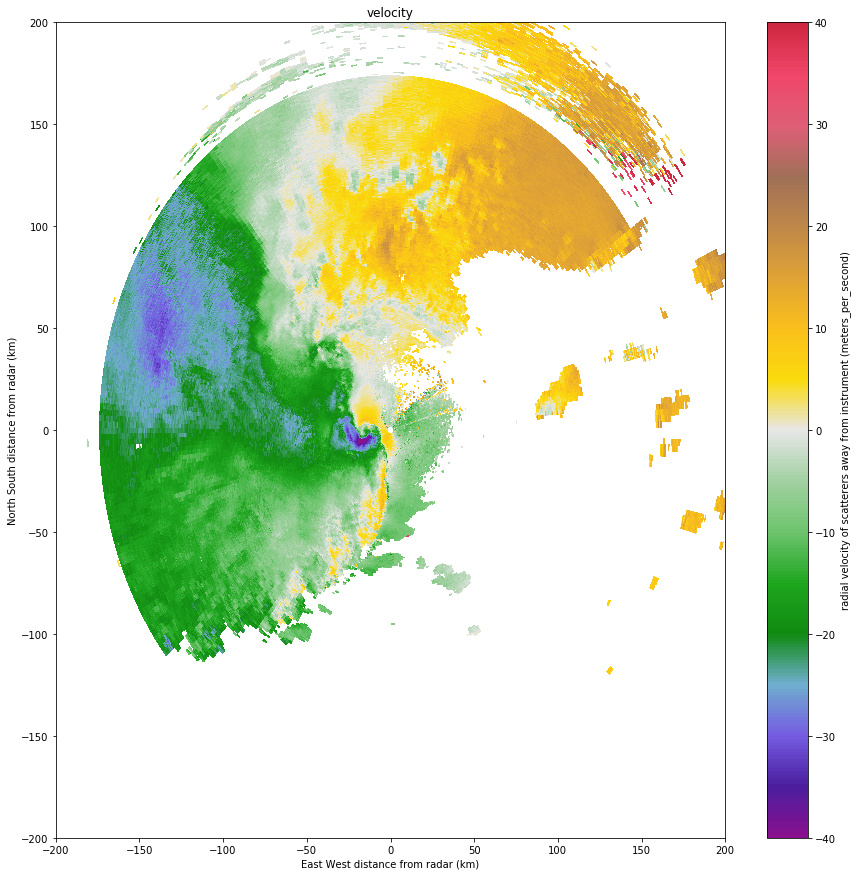

In [25]:
radar2 = pyart.io.read('/Volumes/scr1/26Apr_2016/KLSX_SDUS23_N1ULSX_201604261831')
display = pyart.graph.RadarDisplay(radar2)

fig = plt.figure(figsize = [15,15])
ax = fig.add_subplot(1,1,1)
display.plot('velocity', 0, title='velocity',
                    mask_outside = False,
                    cmap = pyart.graph.cm.Carbone17,
                    vmin = -40, vmax = 40, ax=ax)
display.set_limits(xlim=(-200, 200), ylim=(-200, 200), ax=ax)
plt.show()










In [4]:
LookUp = []
iter_obj = radar.iter_elevation()
for n, elev in enumerate(iter_obj):
    if elev.shape[0] == 720:
        if np.mod(n,2) == 0:
            LookUp.append((n, n+1))
    else:
        LookUp.append((n,n))
   
print LookUp

[(0, 1), (2, 3), (4, 4), (5, 5), (6, 6)]


In [5]:
radar.*?

In [6]:
dbz = radar.get_field(0, 'reflectivity')
zdr = radar.get_field(0, 'differential_reflectivity')
phi = radar.get_field(0, 'differential_phase')
rhv = radar.get_field(0, 'cross_correlation_ratio')
vel = radar.get_field(1, 'velocity')

range = 0.001*radar.range['data'][:]


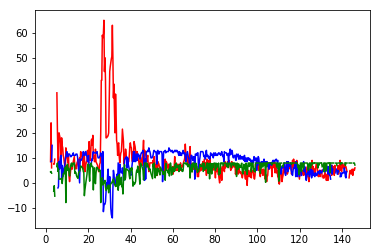

In [7]:
plt.plot(range,dbz[100], color='r'); plt.plot(range,vel[100], color='b'); plt.plot(range,zdr[100], color='g') 
plt.show()

In [8]:
def getAtmosAtten_dynamic(elev):
    atmos = -0.012747 + 0.001895 * elev
    atmos = np.where(atmos < -0.005, -0.005, atmos)
    atmos = np.where(atmos > -0.012, -0.012, atmos)

    return atmos

In [9]:
def calc_SNR(radar):
    
    _C = 31.
    
    snr = np.ma.MaskedArray(np.zeros(radar.fields['reflectivity']['data'].shape))
    
    range_km = 0.001*radar.range['data'][:] + 0.01  # Add 10 m to make sure no zero for log
    
    atmos    = getAtmosAtten_dynamic(radar.elevation['data'])
    
    for n, dbz in enumerate(radar.iter_field('reflectivity')):
        
        if n == 0:
            begin = 0
            end   = radar.sweep_end_ray_index['data'][n] + 1
        else:
            begin = radar.sweep_end_ray_index['data'][n-1] + 1
            end   = radar.sweep_end_ray_index['data'][n] + 1
        
        attenuation = getAtmosAtten_dynamic(radar.elevation['data'][begin:end].mean())
        
        snr[begin:end,:] = (-20.0*np.log10(range_km)) + _C + attenuation*range_km
        
    snr = snr + radar.fields['reflectivity']['data'][:]
    
    radar.add_field_like('reflectivity', 
                         'signal_to_noise_ration', 
                          snr, replace_existing = True)


            
calc_SNR(radar)


In [10]:
def unfold_PHIDP(rhv, phi, fold_in_degrees=360.):
    
    min_system_PhiDP     = 30.0
    min_rhv_thresh       = 0.85
    max_hist_median_size = 30
    half_max_hist_median_size = 25
    max_stddev = fold_in_degrees/3.0
    min_valid_data = 15
    half_fold_in_degrees = fold_in_degrees/2.0
    min_bin_unfold_start  = 300

# not completed....
    return phi
    

In [17]:
def texture(input, radius=3, oneD=False):
    
# oneD flag is used to texture PhiDP along a radial, because it should NOT be a 2D texture
# input_array_dims = [az,range], so texture over second index
  
# ndimage cannot deal with masked arrays - but can deal with nan's - so replace bad values with nan's

    i2     = input.filled(fill_value=np.nan)
    
    if len(i2.shape) == 1 or oneD == True:
        kernel = np.ones((radius))/np.float(radius)
        kernel2 = kernel
    else:
        kernel = np.ones((radius,radius))/np.float(radius**2)
        kernel2 = kernel

    if len(i2.shape) == 2 and oneD == True:       
        std = np.empty_like(input)
        for n in np.arange(i2.shape[0]):
            avg    = scipy.ndimage.filters.convolve(i2[n], kernel2, mode='reflect', origin=0)
            dif    = i2[n] - avg
            c1     = scipy.ndimage.filters.convolve(dif,     kernel, mode='reflect', origin=0)
            c2     = scipy.ndimage.filters.convolve(dif*dif, kernel, mode='reflect', origin=0)
            std[n] = ((c2 - c1*c1)**.5)
    else:
        
        avg    = scipy.ndimage.filters.convolve(i2,      kernel2, mode='reflect', origin=0)
        dif    = i2 - avg
        c1     = scipy.ndimage.filters.convolve(dif,     kernel, mode='reflect', origin=0)
        c2     = scipy.ndimage.filters.convolve(dif*dif, kernel, mode='reflect', origin=0)
        std    = ((c2 - c1*c1)**.5)

    return np.ma.array(std, mask=np.isnan(std))


In [18]:
########################################################################
# Trap4 point

def trap4point( input, y1, y2, y3, y4):

#  abort for poor membership functions
#     if (x2-x1) < 0 or (x3-x2) < 0 or (x4-x3) < 0:
#         return 0

# Error checks for sanity.....

    assert(y2 >= y1)
    assert(y3 >= y2)
    assert(y4 > y3)

# Create vectors for the masking

    x1 = y1*np.ones(input.shape)

    x2 = y2*np.ones(input.shape)

    x3 = y3*np.ones(input.shape)

    x4 = y4*np.ones(input.shape)
    
# create output array
    
    output      = np.ma.zeros(input.shape)
    output.mask = input.mask
    
    mask1 = np.logical_and((input >= x2), (input <= x3))   
    output[mask1] = 1.0
    
    mask2 = np.logical_or((input < x1), (input > x4))
    output[mask2] = 0.0

    mask3 = np.logical_and((input > x1), (input < x2))
    tmp = (input-x1) / (x2-x1)
    output[mask3] = tmp[mask3]

    mask4 = np.logical_and((input > x3), (input < x4))
    tmp = (x4 - input) / (x4-x3)
    output[mask4] = tmp[mask4]
            
    return output

In [19]:
########################################################################
# MetSignal:  Implementation of Krause's 2016 JTech QC algorithm in 2D

def MetSignal(radar, sweep = 0):

    dbz_weight     = 2.0
    rhv_weight     = 1.0
    vel_weight     = 1.0
    std_zdr_weight = 2.0
    std_phi_weight = 2.0
    std_rhv_weight = 1.0
    FLT_MAX        = 1.0e8
    met_threshold  = 79.
    
    v_sweep = 1
    
    dbz = radar.get_field(sweep, 'reflectivity')
    zdr = radar.get_field(sweep, 'differential_reflectivity')
    phi = radar.get_field(sweep, 'differential_phase')
    rhv = radar.get_field(sweep, 'cross_correlation_ratio')
    vel = radar.get_field(v_sweep, 'velocity')

# Calculate the std-deviation for texture mapping

    metsignal = -10.0*np.ones(dbz.shape)
    
    std_phi = texture(phi, radius=9, oneD=True)
    std_zdr = texture(zdr)
    std_rhv = texture(rhv)
    
# Define arrays to store weights from fuzzy logic...

    signal_value    = np.zeros(dbz.shape)
    signal_strength = np.zeros(dbz.shape) 
    weight          = np.zeros(dbz.shape) 
    sump            = np.zeros(dbz.shape, dtype=np.int)
    
# Process 6 fields

    signal_value = signal_value + dbz_weight*trap4point(dbz,10.0,30.0,FLT_MAX,FLT_MAX+1)
    weight       = weight + np.where(dbz.mask == False, dbz_weight, 0.0)
    sump         = sump + np.where(dbz.mask == False, 1, 0) 

    signal_value = signal_value + rhv_weight*trap4point(rhv, 0.75,0.9, FLT_MAX,FLT_MAX+1)
    weight       = weight + np.where(rhv.mask == False, rhv_weight, 0.0) 
    sump         = sump + np.where(rhv.mask == False, 1, 0) 

    signal_value = signal_value + 1.0 - vel_weight*trap4point(vel,-1.5, -1.0, 1.0, 1.5)
    weight       = weight + np.where(vel.mask == False, vel_weight, 0.0) 
    sump         = sump + np.where(vel.mask == False, 1, 0) 

    signal_value = signal_value + std_phi_weight*trap4point(std_phi,0.0, 0.0, 10., 20.)
    weight       = weight + np.where(std_phi.mask == False, std_phi_weight, 0.0) 
    sump         = sump + np.where(std_phi.mask == False, 1, 0) 

    signal_value = signal_value + std_zdr_weight*trap4point(std_zdr,0.0, 0.0, 1., 2.)
    weight       = weight + np.where(std_zdr.mask == False, std_zdr_weight, 0.0) 
    sump         = sump + np.where(std_zdr.mask == False, 1, 0) 

    signal_value = signal_value + std_rhv_weight*trap4point(std_rhv,0.0, 0.0, 0.02, 0.04)
    weight       = weight + np.where(std_rhv.mask == False, std_rhv_weight, 0.0) 
    sump         = sump + np.where(std_rhv.mask == False, 1, 0) 

# Locations with large amounts of Texture are non-meteorlogical while areas 
# with moderate to low amounts of texture are meteorlogical

    metsignal = np.where(sump >= 4, np.floor(100.*signal_value/weight), -10.)
    
# Hardlimits:  Asd some hard thresholds

# RhoHV < 0.65

    mask = np.logical_and((rhv < 0.65), (metsignal >= met_threshold))   
    metsignal = np.where(mask, -5.0, metsignal)

# Zdr < -4.5
    mask = np.logical_and((zdr  < -4.5), (metsignal >= met_threshold))   
    metsignal = np.where(mask, -5.1, metsignal)

# Zdr > 4.5
    mask = np.logical_and((zdr > 4.5), (metsignal >= met_threshold))   
    metsignal = np.where(mask, -5.2, metsignal)

    kernel = np.ones((5,5))/np.float(25)

    metsignal    = scipy.ndimage.filters.convolve(metsignal, kernel, mode='reflect', origin=0)
    
    return metsignal

# Test Trap4point
# print "\n DBZ:  ",trap4point(np.arange(50),10.0,30.0,FLT_MAX,FLT_MAX+1)
# print "\n VEL:  ",trap4point(-5+np.arange(11),-1.5, -1.0, 1.0, 1.5)



 AZ:  51.229248 



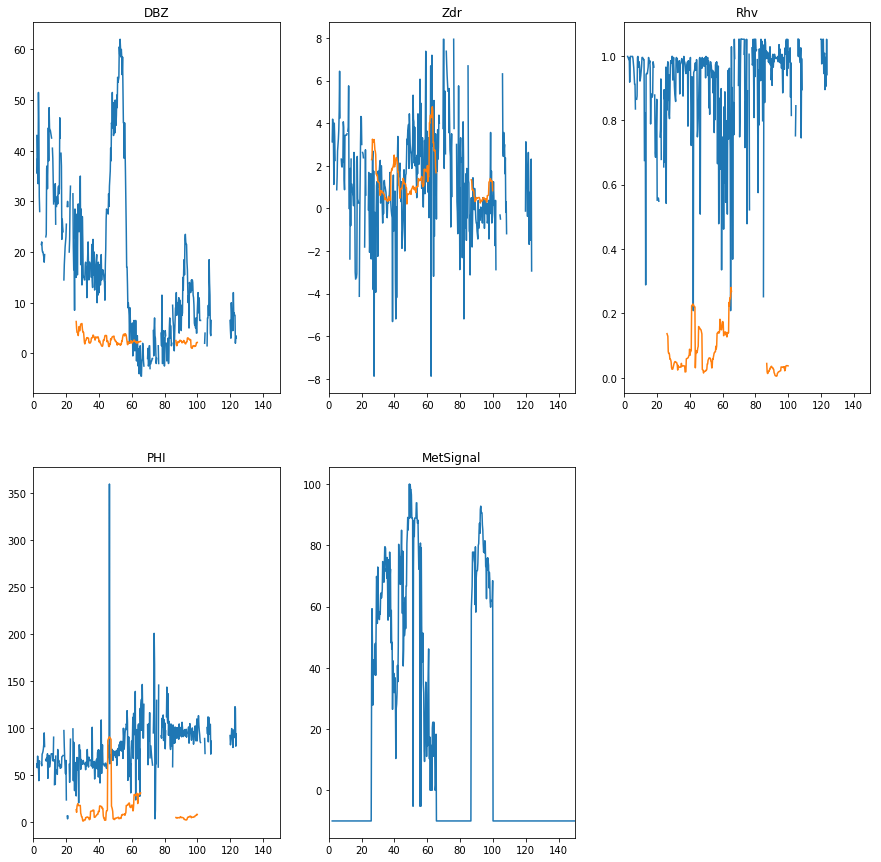

In [15]:
# Single ray processing

na = 90
ran = 150

dbz = radar.get_field(0, 'reflectivity')
zdr = radar.get_field(0, 'differential_reflectivity')
phi = radar.get_field(0, 'differential_phase')
rhv = radar.get_field(0, 'cross_correlation_ratio')
vel = radar.get_field(1, 'velocity')

range = 0.001*radar.range['data'][:]

print("\n AZ:  %f \n" % radar.azimuth['data'][na])

dbz_weight     = 2.0
rhv_weight     = 1.0
vel_weight     = 1.0
std_zdr_weight = 2.0
std_phi_weight = 2.0
std_rhv_weight = 1.0
FLT_MAX        = 1.0e8
met_threshold  = 80.

std_dbz = texture(dbz[na], radius=9)
std_phi = texture(phi[na], radius=9)
std_zdr = texture(zdr[na], radius=9)
std_rhv = texture(rhv[na], radius=9)

metsignal       = -10*np.ones(dbz.shape[1])

signal_value    = np.zeros(dbz.shape[1])
signal_strength = np.zeros(dbz.shape[1]) 
weight          = np.zeros(dbz.shape[1]) 
sump            = np.zeros(dbz.shape[1], dtype=np.int) 


signal_value = signal_value + dbz_weight*trap4point(dbz[na],10.0,30.0,FLT_MAX,FLT_MAX+1)
weight       = weight + np.where(dbz[na].mask == False, dbz_weight, 0.0)
sump         = sump + np.where(dbz[na].mask == False, 1, 0) 

signal_value = signal_value + rhv_weight*trap4point(rhv[na], 0.75,0.9, FLT_MAX,FLT_MAX+1)
weight       = weight + np.where(rhv[na].mask == False, rhv_weight, 0.0) 
sump         = sump + np.where(rhv[na].mask == False, 1, 0) 

signal_value = signal_value + 1.0 - vel_weight*trap4point(vel[na],-1.5, -1.0, 1.0, 1.5)
weight       = weight + np.where(vel[na].mask == False, vel_weight, 0.0) 
sump         = sump + np.where(vel[na].mask == False, 1, 0) 

signal_value = signal_value + std_phi_weight*trap4point(std_phi,0.0, 0.0, 10., 20.)
weight       = weight + np.where(std_phi.mask == False, std_phi_weight, 0.0) 
sump         = sump + np.where(std_phi.mask == False, 1, 0) 

signal_value = signal_value + std_zdr_weight*trap4point(std_zdr,0.0, 0.0, 1., 2.)
weight       = weight + np.where(std_zdr.mask == False, std_zdr_weight, 0.0) 
sump         = sump + np.where(std_zdr.mask == False, 1, 0) 

signal_value = signal_value + std_rhv_weight*trap4point(std_rhv,0.0, 0.0, 0.02, 0.04)
weight       = weight + np.where(std_rhv.mask == False, std_rhv_weight, 0.0) 
sump         = sump + np.where(std_rhv.mask == False, 1, 0) 

metsignal    = np.where(sump >= 4, 100.*signal_value/weight, -10.)

# Hardlimits:  Asd some hard thresholds

# # RhoHV < 0.65

mask = np.logical_and((rhv[na] < 0.65), (metsignal >= met_threshold))   
metsignal = np.where(mask, -5.0, metsignal)

# Zdr < -4.5
mask = np.logical_and((zdr[na]  < -4.5), (metsignal >= met_threshold))   
metsignal = np.where(mask, -5.1, metsignal)

# Zdr > 4.5
mask = np.logical_and((zdr[na] > 4.5), (metsignal >= met_threshold))   
metsignal = np.where(mask, -5.2, metsignal)

fig = plt.figure(figsize = [15, 15])
ax = fig.add_subplot(2,3,1)
plt.plot(range,dbz[na])
plt.plot(range,std_dbz)
ax.set_title('DBZ')
ax.set_xlim(0,ran)

ax = fig.add_subplot(2,3,2)
plt.plot(range,zdr[na]); plt.plot(range,std_zdr)
ax.set_title('Zdr')
ax.set_xlim(0,ran)

ax = fig.add_subplot(2,3,3)
plt.plot(range,rhv[na]); plt.plot(range,std_rhv)
ax.set_title('Rhv')
ax.set_xlim(0,ran)

ax = fig.add_subplot(2,3,4)
plt.plot(range,phi[na]); plt.plot(range,std_phi)
ax.set_title('PHI')
ax.set_xlim(0,ran)

ax = fig.add_subplot(2,3,5)
plt.plot(range,metsignal)
ax.set_xlim(0,ran)
ax.set_title('MetSignal')

plt.show()

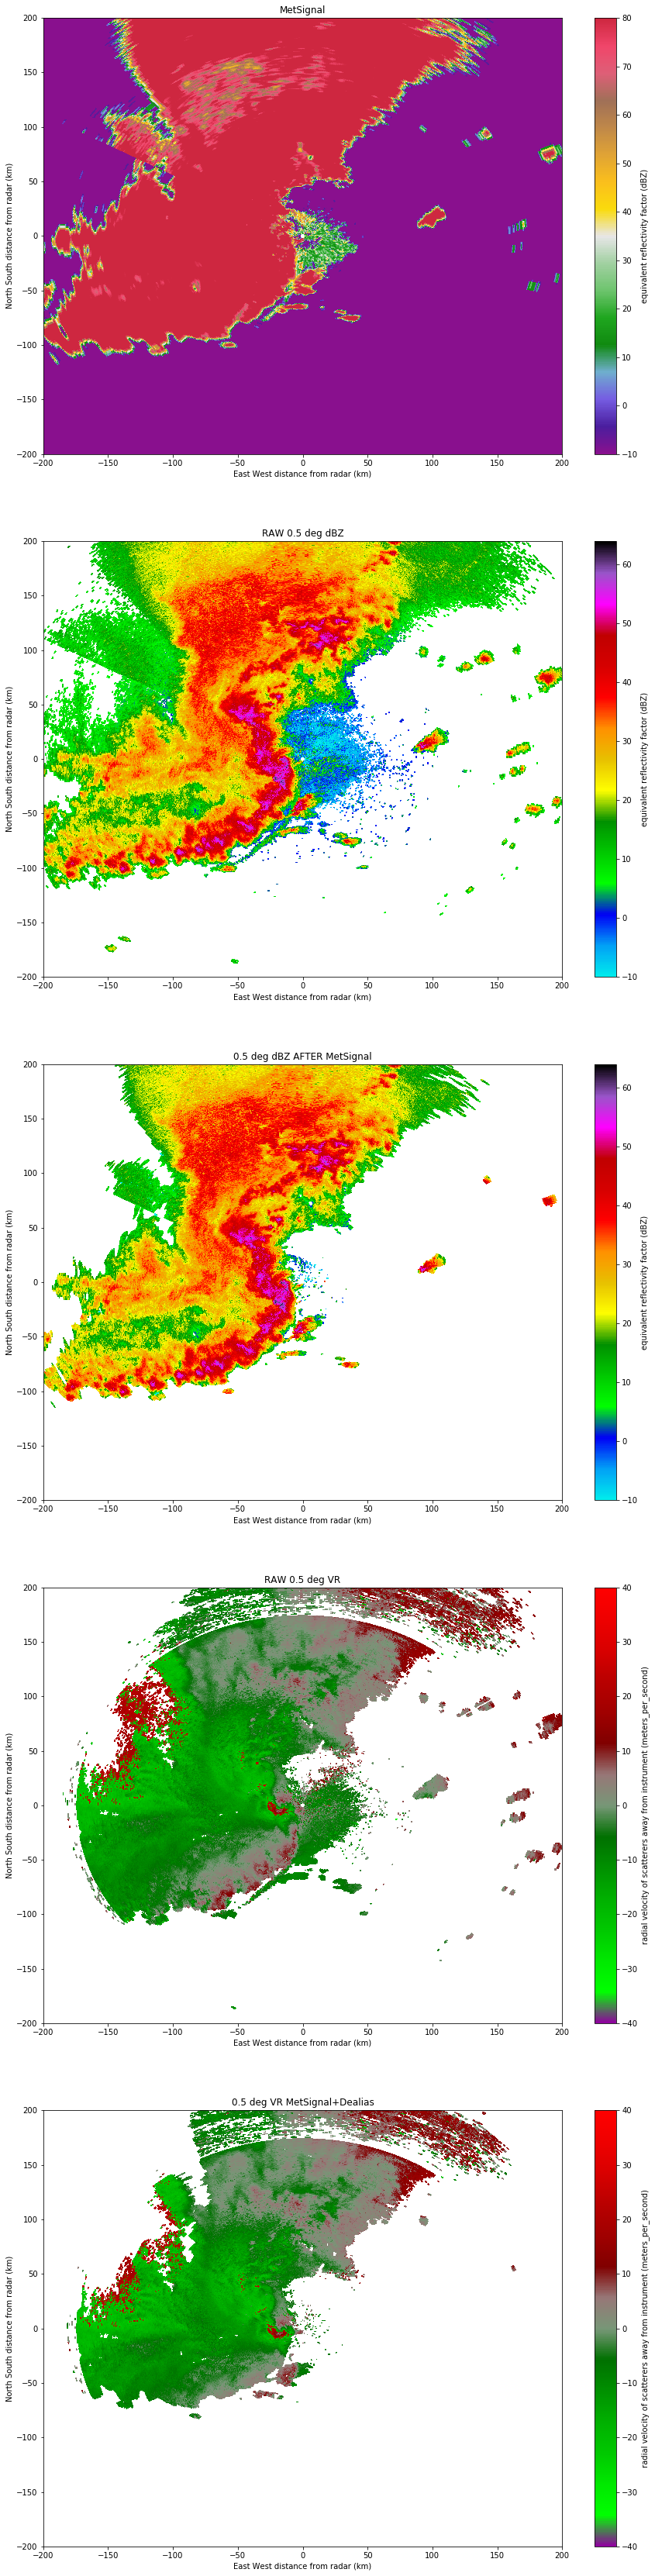

In [26]:
# 2D processing



radar = pyart.io.read('KDDC20160524_181120_V06.gz')
radar = pyart.io.read('KDDC20160525_001527_V06.gz')
radar = pyart.io.read('/Volumes/scr1/26Apr_2016/KLSX20160426_183137_V06')

metsignal_thres = 50

dbz = radar.get_field(0, 'reflectivity')
zdr = radar.get_field(0, 'differential_reflectivity')
phi = radar.get_field(0, 'differential_phase')
rhv = radar.get_field(0, 'cross_correlation_ratio')
vel = radar.get_field(1, 'velocity')

gatefilter = pyart.correct.GateFilter(radar)
# gatefilter.exclude_invalid('velocity')
# gatefilter.exclude_invalid('reflectivity')
# gatefilter.exclude_masked('reflectivity')

metsignal = np.zeros(radar.fields['reflectivity']['data'].shape)

metsignal[0:720,:] = MetSignal(radar)

metsig_mask = (metsignal < 80.)

radar.add_field_like('reflectivity', 
                     'MetSignal', 
                     metsignal, replace_existing = True)

# Plot the before and after lowest tilts...

display = pyart.graph.RadarDisplay(radar)

fig = plt.figure(figsize = [15,60])
ax = fig.add_subplot(5,1,1)
display.plot('MetSignal', 0, title='MetSignal',
                    mask_outside = False,
                    cmap = pyart.graph.cm.Carbone17,
                    vmin = -10, vmax = 80, ax=ax)
display.set_limits(xlim=(-200, 200), ylim=(-200, 200), ax=ax)

ax = fig.add_subplot(5,1,2)
display.plot('reflectivity', 0, title="RAW 0.5 deg dBZ",
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    vmin = -10, vmax = 64, ax=ax)

display.set_limits(xlim=(-200, 200), ylim=(-200, 200), ax=ax)

# QC the reflectivity field

ax = fig.add_subplot(5,1,3)

dbz_metsignal = np.empty_like(radar.fields['reflectivity']['data'])
dbz_metsignal.data[0:720,:] = np.where(metsignal[0:720,:] < metsignal_thres, -9999., dbz)
dbz_metsignal.mask[0:720,:] = np.where(metsignal[0:720,:] < metsignal_thres, True, False)

radar.add_field_like('reflectivity', 
                     'reflectivity_metsignal', 
                     dbz_metsignal, replace_existing = True)

display.plot('reflectivity_metsignal', 0, title="0.5 deg dBZ AFTER MetSignal",
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    vmin = -10, vmax = 64, ax=ax)
display.set_limits(xlim=(-200, 200), ylim=(-200, 200), ax=ax)


ax = fig.add_subplot(5,1,4)
display.plot('velocity', 1, title="RAW 0.5 deg VR",
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSVel,
                    vmin = -40, vmax = 40, ax=ax)

display.set_limits(xlim=(-200, 200), ylim=(-200, 200), ax=ax)

# QC the velocity field

ax = fig.add_subplot(5,1,5)

dbz_metsignal = np.empty_like(radar.fields['reflectivity']['data'])
type(dbz_metsignal)
dbz_metsignal.data[720:1440,:] = vel[0:720,:]
dbz_metsignal.mask[720:1440,:] = np.where(metsignal[0:720,:] < metsignal_thres, True, False)

radar.add_field_like('velocity', 
                     'velocity_metsignal', 
                      dbz_metsignal, replace_existing = True)

gatefilter.exclude_invalid('velocity_metsignal')
gatefilter.exclude_masked('velocity_metsignal')

# dealiased_radar = pyart.correct.dealias_unwrap_phase(radar, unwrap_unit='sweep',
#                                nyquist_vel=None, check_nyquist_uniform=True,
#                                gatefilter=gatefilter, rays_wrap_around=None,
#                                keep_original=False, set_limits=True,
#                                vel_field='velocity', corr_vel_field=None,
#                                skip_checks=False)

# dealiased_radar = pyart.correct.dealias_region_based(radar, interval_splits=3,
#                                    interval_limits=None, skip_between_rays=100,
#                                    skip_along_ray=100, centered=True,
#                                    nyquist_vel=None, check_nyquist_uniform=True,
#                                    gatefilter=gatefilter, rays_wrap_around=None,
#                                    keep_original=False, set_limits=True,
#                                    vel_field='velocity', corr_vel_field=None)


#radar.add_field('unfolded velocity', dealiased_radar)
ax = fig.add_subplot(5,1,5)
display.plot('velocity_metsignal', 1,  title="0.5 deg VR MetSignal+Dealias",
                    mask_outside = True,
                    cmap = pyart.graph.cm.NWSVel,
                    vmin = -40, vmax = 40, ax=ax)

display.set_limits(xlim=(-200, 200), ylim=(-200, 200), ax=ax)

plt.show()



In [26]:
dbz = radar.get_field(0, 'reflectivity')
zdr = radar.get_field(0, 'differential_reflectivity')
phi = radar.get_field(0, 'differential_phase')
rhv = radar.get_field(0, 'cross_correlation_ratio')
vel = radar.get_field(1, 'velocity')

dbz_int = 100*((dbz.max()-dbz)/100.)
dbz_int = dbz_int.astype(np.int32)
print dbz_int.max(), dbz_int.min()

out = scipy.ndimage.find_objects(dbz_int)



87 0


In [28]:
out.*?
